In [2]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [3]:

# Load data
shapes = pd.read_csv('gtfs/shapes.txt')
trips = pd.read_csv('gtfs/trips.txt')
routes = pd.read_csv('gtfs/routes.txt')
stop_times = pd.read_csv('gtfs/stop_times.txt')
stops = pd.read_csv('gtfs/stops.txt')

In [23]:


# Create directed graph with trip frequency weights
G = nx.DiGraph()

# Add nodes (bus stops)
for _, stop in stops.iterrows():
    G.add_node(stop['stop_id'], 
               pos=(stop['stop_lon'], stop['stop_lat']),
               name=stop['stop_name'])

# Add weighted edges
stop_times_sorted = stop_times.sort_values(['trip_id', 'stop_sequence'])
for (prev_stop, current_stop), count in stop_times_sorted.groupby(
    [stop_times['stop_id'].shift(), 'stop_id']).size().items():
    if pd.notna(prev_stop):
        G.add_edge(prev_stop, current_stop, weight=count)

# Calculate Eigenvector Centrality
eigen_centrality = nx.eigenvector_centrality(G, max_iter=500, weight='weight')
stops['centrality'] = stops['stop_id'].map(eigen_centrality)

In [7]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes (bus stops): {num_nodes}")
print(f"Number of edges (connections): {num_edges}")

density = nx.density(G)
print(f"Graph density: {density:.4f}")

in_degrees = dict(G.in_degree(weight='weight'))
out_degrees = dict(G.out_degree(weight='weight'))
print(f"Top 5 stops by in-degree: {sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 stops by out-degree: {sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]}")

Number of nodes (bus stops): 3055
Number of edges (connections): 4552
Graph density: 0.0005
Top 5 stops by in-degree: [('stop_1654_314104', 4642), ('stop_237_31903', 3953), ('stop_1654_314105', 3953), ('stop_1626_311102', 3940), ('stop_237_31904', 3933)]
Top 5 stops by out-degree: [('stop_1654_314104', 4642), ('stop_237_31903', 3953), ('stop_1654_314105', 3953), ('stop_1626_311102', 3940), ('stop_237_31904', 3933)]


In [8]:
top_centrality = sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 stops by eigenvector centrality:")
for stop_id, centrality in top_centrality:
    stop_name = stops.loc[stops['stop_id'] == stop_id, 'stop_name'].values[0]
    print(f"Stop ID: {stop_id}, Name: {stop_name}, Centrality: {centrality:.4f}")

Top 5 stops by eigenvector centrality:
Stop ID: stop_432_61003, Name: Rondo Matecznego, Centrality: 0.3795
Stop ID: stop_439_62001, Name: Kamieńskiego, Centrality: 0.3580
Stop ID: stop_2108_333803, Name: Rondo Grunwaldzkie, Centrality: 0.3147
Stop ID: stop_1200_280801, Name: Ludwinów, Centrality: 0.2629
Stop ID: stop_438_61901, Name: Kamieńskiego Wiadukt, Centrality: 0.2558


Betweenness centrality measures how often a node lies on the shortest path between other nodes:

In [9]:
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 stops by betweenness centrality:")
for stop_id, centrality in top_betweenness:
    stop_name = stops.loc[stops['stop_id'] == stop_id, 'stop_name'].values[0]
    print(f"Stop ID: {stop_id}, Name: {stop_name}, Centrality: {centrality:.4f}")

Top 5 stops by betweenness centrality:
Stop ID: stop_1362_303804, Name: Czerwone Maki P+R, Centrality: 0.2363
Stop ID: stop_530_74704, Name: Borek Fałęcki, Centrality: 0.2003
Stop ID: stop_2260_344101, Name: Skawina SCK, Centrality: 0.1918
Stop ID: stop_2961_372404, Name: Krowodrza Górka P+R, Centrality: 0.1903
Stop ID: stop_333_329974, Name: Pleszów, Centrality: 0.1618


In [27]:
stop_id_1 = 'some_stop_id'
stop_id_2 = 'another_stop_id'
try:
    shortest_path = nx.shortest_path(G, source=stop_id_1, target=stop_id_2, weight='weight')
    print(f"Shortest path from {stop_id_1} to {stop_id_2}: {shortest_path}")
except nx.NetworkXNoPath:
    print(f"No path exists between {stop_id_1} and {stop_id_2}.")

NodeNotFound: Source some_stop_id is not in G

In [17]:
print(stops[stops['stop_id'] == 'stop_1132_268804'])
print(stop_times[stop_times['stop_id'] == 'stop_1132_268804'])

Empty DataFrame
Columns: [stop_id, stop_code, stop_name, stop_desc, stop_lat, stop_lon, zone_id, stop_url, location_type, parent_station, stop_timezone, wheelchair_boarding, centrality]
Index: []
                            trip_id arrival_time departure_time  \
598519   block_521_trip_7_service_1     24:20:00       24:20:00   
598577   block_521_trip_9_service_1     27:20:00       27:20:00   
598664   block_522_trip_3_service_1     25:20:00       25:20:00   
598722   block_522_trip_5_service_1     28:20:00       28:20:00   
598872   block_523_trip_7_service_1     26:20:00       26:20:00   
787414  block_2205_trip_7_service_5     24:20:00       24:20:00   
787472  block_2205_trip_9_service_5     27:20:00       27:20:00   
787559  block_2206_trip_3_service_5     25:20:00       25:20:00   
787617  block_2206_trip_5_service_5     28:20:00       28:20:00   
787767  block_2207_trip_7_service_5     26:20:00       26:20:00   

                 stop_id  stop_sequence  stop_headsign  pickup_typ

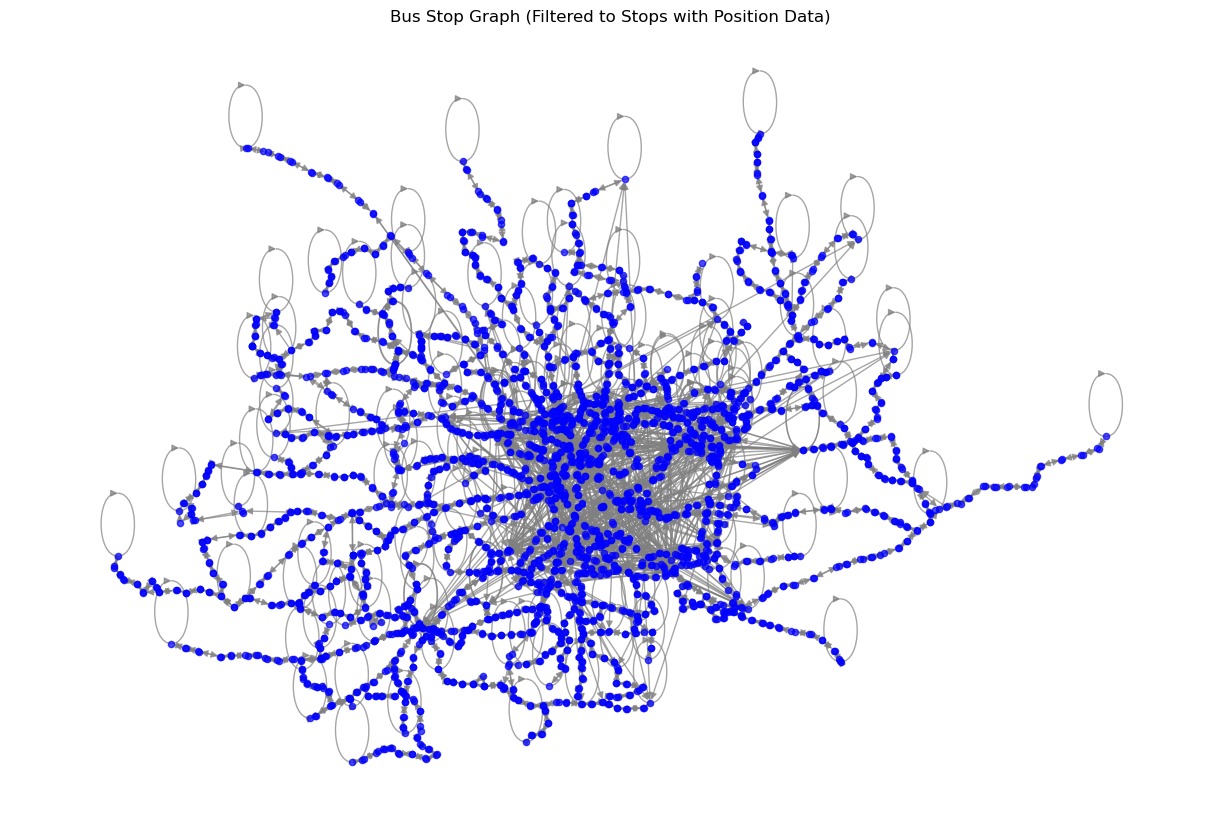

In [25]:
import matplotlib.pyplot as plt
# Get only the nodes that have position data
pos = nx.get_node_attributes(G, 'pos')

nodes_with_pos = list(pos.keys())

# Create a subgraph with only these nodes
G_with_pos = G.subgraph(nodes_with_pos)

# Draw the filtered graph
plt.figure(figsize=(12, 8))
nx.draw(
    G_with_pos, pos, with_labels=False, node_size=20, 
    node_color='blue', edge_color='gray', alpha=0.7
)
plt.title("Bus Stop Graph (Filtered to Stops with Position Data)")
plt.show()

Removing 45 nodes without position data


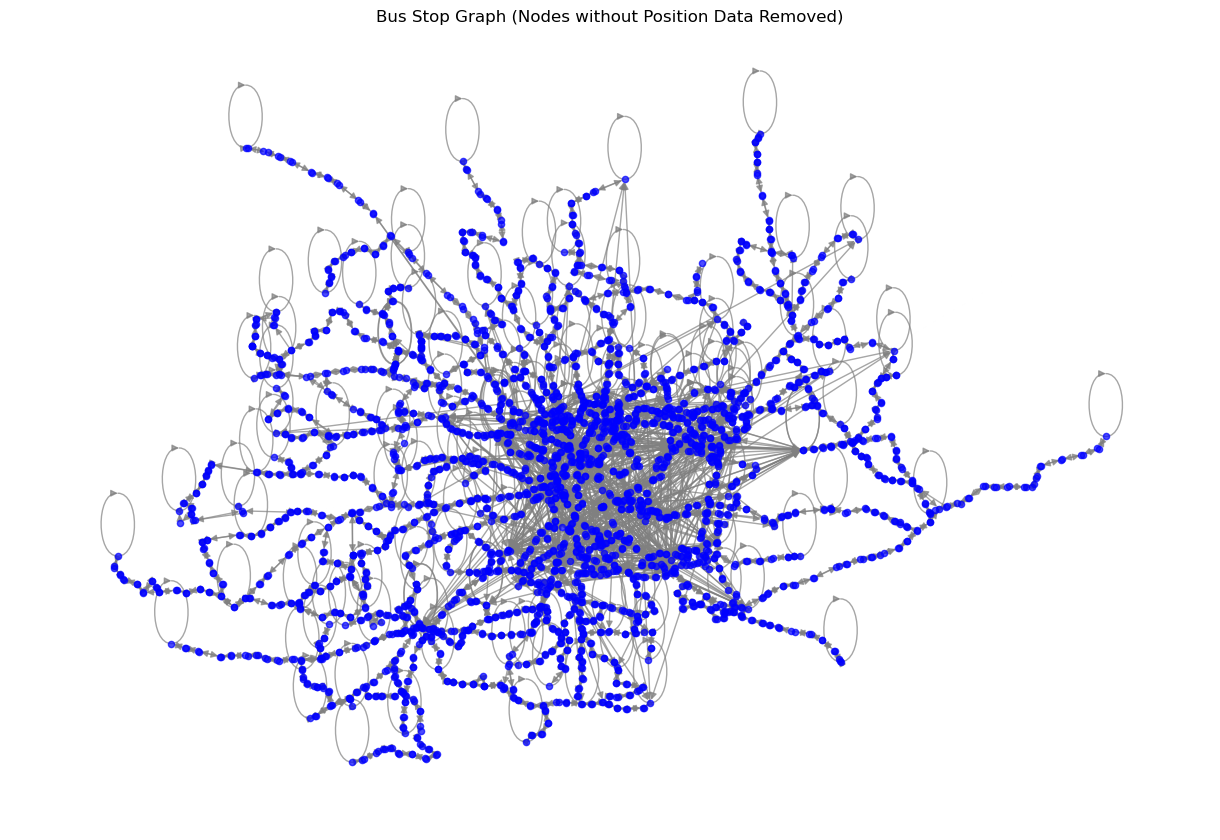

In [26]:
# Remove nodes without position data from the graph
pos = nx.get_node_attributes(G, 'pos')

nodes_to_remove = [node for node in G.nodes() if node not in pos]
print(f"Removing {len(nodes_to_remove)} nodes without position data")
G.remove_nodes_from(nodes_to_remove)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=False, node_size=20, 
    node_color='blue', edge_color='gray', alpha=0.7
)
plt.title("Bus Stop Graph (Nodes without Position Data Removed)")
plt.show()

In [ ]:
# Create base map
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scattermapbox'}]])
fig.update_layout(mapbox_style="carto-darkmatter", height=800, margin={"r":0,"t":0,"l":0,"b":0})

# Add route geometries from shapes.txt
for shape_id, group in shapes.groupby('shape_id'):
    fig.add_trace(go.Scattermapbox(
        lon=group['shape_pt_lon'],
        lat=group['shape_pt_lat'],
        mode='lines',
        line=dict(width=1, color='rgba(100, 100, 100, 0.4)'),
        hoverinfo='none',
        showlegend=False
    ))

# Add bus stops with centrality coloring
fig.add_trace(go.Scattermapbox(
    lon=stops['stop_lon'],
    lat=stops['stop_lat'],
    mode='markers',
    marker=dict(
        size=8,
        color=stops['centrality'],
        colorscale='YlOrRd',
        showscale=True,
        colorbar=dict(title='Eigenvector Centrality')
    ),
    text=stops.apply(lambda x: f"{x['stop_name']}<br>Centrality: {x['centrality']:.4f}", axis=1),
    hoverinfo='text',
    name='Bus Stops'
))

# Add animated buses (simulated)
bus_positions = trips.merge(stop_times, on='trip_id')\
                        .merge(stops, on='stop_id')
bus_positions = bus_positions.sample(50)


# fig.add_trace(go.Scattermapbox(
#     lon=bus_positions['stop_lon'],
#     lat=bus_positions['stop_lat'],
#     mode='markers+text',
#     marker=dict(size=12, color='#00FF00', symbol='bus'),
#     text='🚌',
#     textposition='middle center',
#     name='Active Buses'
# ))

# fig.update_layout(
#     mapbox=dict(
#         zoom=11,
#         center=dict(lat=50.06, lon=19.94)
#     )
# )

# fig.show()

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_37676/2979866703.py:7: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [ ]:
# Top 10 central nodes
top_nodes = stops.nlargest(10, 'centrality')[['stop_id', 'stop_name', 'centrality']]

# Route betweenness analysis
edge_betweenness = nx.edge_betweenness_centrality(G, weight='weight')
busiest_routes = pd.Series(edge_betweenness).nlargest(5)

print("Most Important Stops:")
print(top_nodes)
print("\nBusiest Route Segments:")
print(busiest_routes)